# 🚂 **Analyse du réseau ferré de la SNCF: Comment expliquer les retards permanents de la compagnie française ?** 🚂

Comme tous bons étudiants provinciaux du plateau de Saclay, nous avons régulièrement eu à faire aux retards inéluctables des trains de la SNCF. A l'heure où ce moyen de transport est destiné à remplacer l'aviation civile ultra-polluante, nous avons voulu analyser l'évolution et les causes des retards que subissent fréquemment les usagers du réseau ferré français. 

Nous avons construit notre analyse à partir de différentes bases de données rendues publiques et entretenues par la SNCF. Ce travail a vocation à répondre aux exigences du cours de **Python pour la Data Science** de 2ème année de l'ENSAE Paris et s'articule en 3 axes: 
- Récupération et traitement des données
- Analyse descriptive et représentation graphique
- Modélisation 

Tout au long de ce notebook, nous ferons appel aux fonctions définies dans le fichier **fonctions.py**. A la fin du travail d'analyse, nous vous proposons également un petit jeu intéractif bonus à ouvrir dans un autre éditeur de code que Jupyter. 


*Les cellules les plus longues (importation de données) prennent au maximum une quinzaine de secondes.*

## **1. RÉCUPÉRATION DE DONNÉES : importation et traitement des données de l'API de la SNCF**

Nous importons les packages et les fonctions définies dans le fichier **fonction.py**

In [1]:
from fonctions import *

Nous avons commencé notre travail sur le site de l'API SNCF https://ressources.data.sncf.com/api/v2/console. Il propose d'accéder à plus de 216 datasets qui regroupent différents types de données. Le premier fichier que nous avons étudié est le **Catalogue** qui présente tous les autres datasets disponnibles. C'est à partir de ce **Catalogue** que nous avons pu identifier les différents datasets utiles à nos analyses.

In [2]:
df_catalogue = importer("https://ressources.data.sncf.com/api/v2/catalog/exports/json?limit=-1&offset=0&timezone=UTC")
pd.DataFrame(df_catalogue['dataset_id']).head()

,dataset_id
0,liste-des-circuits-de-voie
1,rapports-irc
2,frequence-gare
3,saisines-avis-mediateur-sncf
4,tarifs-ter-par-od


### **1.1 Analyse de la répartition/fréquentation des gares de la SNCF**

Nous avons voulu identifier les stations SNCF les plus fréquentées afin d'avoir une meilleure idée du maillage du réseau ferré français. Nous allons chercher les données qui nous interessent dans les datasets **liste_des_gares** et **frequentations_gares disponnibles** sur l'API de la SNCF.

#### **1.1.1 Importation des données**

In [3]:
#importation de la liste des gares, API SNCF (peut prendre une quinzaine de secondes)
df_gares = importer("https://ressources.data.sncf.com/api/v2/catalog/datasets/liste-des-gares/exports/json?limit=-1&offset=0&timezone=UTC")
df_gares.head(2)

,code_uic,libelle,fret,voyageurs,code_ligne,rg_troncon,pk,commune,departemen,idreseau,idgaia,x_l93,y_l93,x_wgs84,y_wgs84,c_geo,geo_point_2d,geo_shape
0,87755223,Bandol,N,O,930000,1,050+607,BANDOL,VAR,3077,29a5a626-dfbc-11e3-a2ff-01a464e0362d,923833.7169,6.230702e+06,5.749816,43.140491,"{'lon': 5.749815526229215, 'lat': 43.140491048...","{'lon': 5.749815526229215, 'lat': 43.140491047...","{'type': 'Feature', 'geometry': {'coordinates'..."
1,87696179,Pouilly-sur-Loire,O,O,750000,1,214+004,POUILLY-SUR-LOIRE,NIEVRE,6141,297a4c76-dfbc-11e3-a2ff-01a464e0362d,697358.2537,6.686913e+06,2.965051,47.282528,"{'lon': 2.965051211539136, 'lat': 47.282528482...","{'lon': 2.965051211539134, 'lat': 47.282528481...","{'type': 'Feature', 'geometry': {'coordinates'..."


In [4]:
"""
#si erreur "Max retries exceeded with url" dans la cellule précédente, utiliser cette cellule

import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

session = requests.Session()
retry = Retry(connect=3, backoff_factor=0.5)
adapter = HTTPAdapter(max_retries=retry)
session.mount('http://', adapter)
session.mount('https://', adapter)

session.get(url_retards)
"""

'\n#si erreur "Max retries exceeded with url" dans la cellule précédente, utiliser cette cellule\n\nimport requests\nfrom requests.adapters import HTTPAdapter\nfrom urllib3.util.retry import Retry\n\nsession = requests.Session()\nretry = Retry(connect=3, backoff_factor=0.5)\nadapter = HTTPAdapter(max_retries=retry)\nsession.mount(\'http://\', adapter)\nsession.mount(\'https://\', adapter)\n\nsession.get(url_retards)\n'

In [5]:
#importation des données sur la frequentation des gares, API SNCF
df_freq_gares = importer("https://ressources.data.sncf.com/api/v2/catalog/datasets/frequentation-gares/exports/json?limit=-1&offset=0&timezone=UTC")
df_freq_gares.head(2)

,nom_gare,code_uic_complet,code_postal,segmentation_drg,total_voyageurs_2021,total_voyageurs_non_voyageurs_2021,total_voyageurs_2020,total_voyageurs_non_voyageurs_2020,total_voyageurs_2019,total_voyageurs_non_voyageurs_2019,total_voyageurs_2018,total_voyageurs_non_voyageurs_2018,totalvoyageurs2017,total_voyageurs_non_voyageurs_2017,total_voyageurs_2016,total_voyageurs_non_voyageurs_2016,total_voyageurs_2015,total_voyageurs_non_voyageurs_2015
0,Abbaretz,87481614,44170,c,27466,27466,22773,22773,38473,38473,38027,38027,35637,35637,33021,33021,35989,35989
1,Aéroport Charles de Gaulle 1,87271460,93290,b,3460437,3460437,2177954,2177954,7971396,7971396,7590098,7590098,7199779,7199779,6690263,6690263,6226179,6226179


In [6]:
#comparaison du nombre de données (moins de données sur la fréquentation)
print(len(df_freq_gares))
print(len(df_gares))

2970
3819


#### **1.1.2 Constitution de la base de données (nettoyage, fusion, et concaténation de données)**

Nous retravaillons les 2 datasets importés afin de créer notre base de données des gares SNCF les plus fréquentées.

In [7]:
#Harmonisation du nom de la colonne code_uic en vue du merge
df_freq_gares.rename(columns = {'code_uic_complet':'code_uic'}, inplace = True)

In [8]:
#On regarde quelles gares du dataframe "liste des gares" ne sont pas dans le dataframe "frequentations"
outer_merged = pd.merge(df_gares, df_freq_gares, how="outer", on=["code_uic"])
outer_merged[outer_merged['nom_gare'].isna()==True][['code_uic', 'libelle']]

,code_uic,libelle
3,87784488,Cases-de-Pène
12,87396671,La Chartre-sur-le-Loir
35,87271320,La Courneuve-Dugny
39,87172411,Margut-Fromy
49,87172593,Vouziers
...,...,...
3785,87286807,Genech
3793,87755835,La Motte-Ste-Rosseline
3799,87729210,Port-Fluvial-de-Chalon-sur-Saône
3801,87286252,Rougebarre


Ce ne sont que des petites gares et comme nous nous intéressons aux gares les plus fréquentées, nous allons seulement considérer celles qui apparaissent dans le dataset des fréquentations.

In [9]:
#Fusion des dataframes sur la base de df_freq_gares avec un left merge
left_merged = pd.merge(df_freq_gares, df_gares, how="left", on=["code_uic"])
df_gares_merged = left_merged[['code_uic','total_voyageurs_non_voyageurs_2020', 'nom_gare', 'x_wgs84','y_wgs84']]
df_gares_merged.head(2)

,code_uic,total_voyageurs_non_voyageurs_2020,nom_gare,x_wgs84,y_wgs84
0,87481614,22773,Abbaretz,-1.524313,47.555462
1,87271460,2177954,Aéroport Charles de Gaulle 1,2.555964,49.008827


In [10]:
#Elimination des gares dont la frequentation est nulle
df_gares_merged = df_gares_merged.drop(df_gares_merged[df_gares_merged['total_voyageurs_non_voyageurs_2020']==0].index)

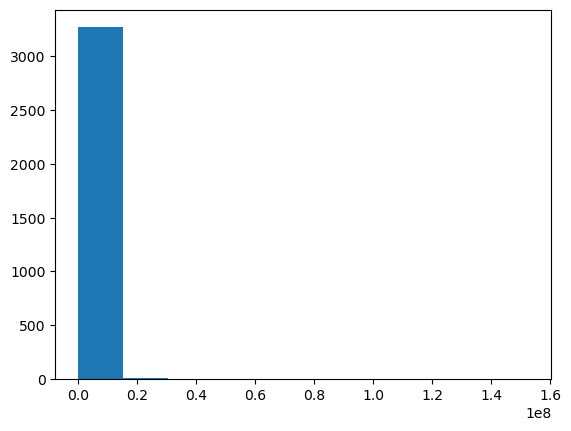

In [11]:
#Visualisation de la répartition des fréquentations par gare
plt.hist(df_gares_merged['total_voyageurs_non_voyageurs_2020'])
plt.show()

Pour mieux apprécier les fréquentations, il est nécessaire de passer au log.

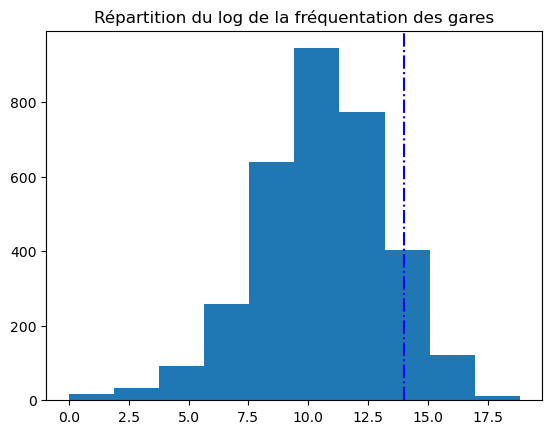

In [12]:
df_gares_merged['log_total_voyageurs_non_voyageurs_2020'] = np.log(df_gares_merged['total_voyageurs_non_voyageurs_2020'])
plt.hist(df_gares_merged['log_total_voyageurs_non_voyageurs_2020'])
plt.title("Répartition du log de la fréquentation des gares")
plt.axvline(x = 14, color = 'b', linestyle = '-.')
plt.show()

In [13]:
#Application d'un filtre sur les frequentations : on ne garde que les gares les plus frequentées (à droite de la droite verticale bleue)
df_gares_principales = df_gares_merged[df_gares_merged['log_total_voyageurs_non_voyageurs_2020']>= 14]

Nous identifions maintenant les gares très fréquentées pour lesquelles il nous manque les coordonnées GPS. A savoir, les gares qui sont dans le dataset des fréquentations mais pas dans celui de la liste des gares

In [14]:
df_gares_manquantes  = df_gares_principales[df_gares_principales['x_wgs84'].isna()==True]
df_gares_manquantes

,code_uic,total_voyageurs_non_voyageurs_2020,nom_gare,x_wgs84,y_wgs84,log_total_voyageurs_non_voyageurs_2020
384,87756403,4085871,Monaco-Monte-Carlo,NaN,NaN,15.223045
664,87113795,3664906,Villiers-sur-Marne - Le Plessis-Trévise,NaN,NaN,15.114313
1195,87113704,2380920,Rosny-sous-Bois,NaN,NaN,14.682998
1488,87758607,7980634,Châtelet les Halles,NaN,NaN,15.892528
1533,87116046,2496908,Émerainville - Pontault-Combault,NaN,NaN,14.730564
1806,87113209,3862190,Pantin,NaN,NaN,15.166745
1808,87758904,107666015,Paris Gare du Nord,NaN,NaN,18.494545
1852,87654798,2865667,Rosa Parks,NaN,NaN,14.868312
1855,87113696,3206275,Rosny Bois Perrier,NaN,NaN,14.980620
2347,87113522,1562549,Le Chénay Gagny,NaN,NaN,14.261829


- **Problème** : il nous manque les données GPS de gares importantes (la gare de Paris EST par exemple)
- **Solution** : ces gares étant -presque- toutes situées en région Ile de France (idf) on va aller chercher ces données sur l'API de la région idf.

Nous identifions donc les données manquantes de ce dataframe et les importons à partir de l'API idf (il nous manquera tout de même la gare de Monaco mais nous ne la prendrons pas en compte, il ne s'agit que d'une gare et Monaco n'est pas en France).

In [15]:
#Elimination des gares dont on ne connait pas la fréquentation
df_gares_principales = df_gares_principales[df_gares_principales['x_wgs84'].isna()==False]

In [16]:
#Récupération des données manquantes (sauf Monaco) grâce à l'API de la région idf
df_region_idf_initial = importer("https://data.iledefrance.fr/api/v2/catalog/datasets/gares-et-points-darrets-du-reseau-transilien/exports/json?limit=-1&offset=0&timezone=UTC")

#On se restreint aux gares dont les données geographiques sont manquantes dans le dataframe des gares principales
df_region_idf = df_region_idf_initial[df_region_idf_initial.code_uic.isin(df_gares_manquantes['code_uic'])==True]
df_region_idf

,code_uic,uic7,libelle_point_d_arret,libelle,libelle_stif_info_voyageurs,libelle_sms_gare,nom_gare,adresse,code_insee_commune,commune,x_lambert_ii_etendu,y_lambert_ii_etendu,coord_gps_wgs84,zone_navigo,gare_non_sncf
62,87113209,871132,PANTIN,PANTIN,GARE DE PANTIN,Pantin,Pantin,Avenue de la gare 93500 Pantin,93055,[Pantin],604688.0,2433279.0,"{'lon': 2.40040674765, 'lat': 48.8977738494}",2.0,0.0
166,87116038,871160,ROISSY EN BRIE,ROISSY EN BRIE,GARE DE ROISSY EN BRIE,Roissy en B.,Roissy-en-Brie,Place de la gare 77680 Roissy-en-Brie,77390,[Roissy-en-Brie],623033.0,2421933.0,"{'lon': 2.64984936854, 'lat': 48.7954076773}",5.0,0.0
207,87113696,871136,ROSNY BOIS PERRIER,ROSNY BOIS PERRIER,GARE DE ROSNY BOIS PERRIER,Rosny B. P.,Rosny-sous-Bois Perrier,Rue Léon Blum 93110 Rosny sous bois,93064,[Rosny-sous-Bois],610640.0,2431610.0,"{'lon': 2.48149612336, 'lat': 48.8827036731}",3.0,0.0
228,87654798,876547,Rosa Parks,Rosa Parks,GARE DE ROSA PARKS,None,Rosa Parks,Rue Gaston Tessier,75119,[Paris],602710.0,2433136.0,"{'lon': 2.37345, 'lat': 48.8965}",1.0,0.0
241,87113522,871135,LE CHENAY GAGNY,LE CHENAY GAGNY,GARE DE CHENAY GAGNY,Chenay-Gagny,Gagny le Chênay,5 rue du chemin de fer 93220 Gagny,93032,[Gagny],615860.0,2431016.0,"{'lon': 2.5526064160699997, 'lat': 48.8772579359}",4.0,0.0
326,87113795,871137,VILLIERS SUR MARNE PLESSIS TREVISE,VILLIERS SUR MARNE PLESSIS TREVISE,GARE DE VILLIERS SUR MARNE PLESSIS TREVISE,Villiers,Villiers-sur-Marne - Le Plessis-Trévise,place Pierre Sémard 94350 VILLIERS-SUR-MARNE,94079,[Villiers-sur-Marne],615121.0,2424997.0,"{'lon': 2.54232320839, 'lat': 48.8231802547}",4.0,0.0
327,87113779,871137,LES BOULLEREAUX CHAMPIGNY,LES BOULLEREAUX CHAMPIGNY,GARE DES BOULLEREAUX CHAMPIGNY,Boullereaux,Les Boullereaux Champigny,Avenue Danielle Casanova 94500 Champigny sur M...,94017,[Champigny-sur-Marne],612900.0,2425186.0,"{'lon': 2.51209824083, 'lat': 48.8249271629}",3.0,0.0
341,87113746,871137,NOGENT LE PERREUX,NOGENT LE PERREUX,GARE DE NOGENT LE PERREUX,Nogent le P.,Nogent - Le Perreux,place du Théâtre 94130 NOGENT-SUR-MARNE,94052,[Nogent-sur-Marne],611573.0,2426718.0,"{'lon': 2.4940770412199997, 'lat': 48.8387213192}",3.0,0.0
369,87113712,871137,VAL DE FONTENAY,VAL DE FONTENAY,GARE DE VAL DE FONTENAY,Val de Font.,Val de Fontenay,10 avenue du Val de Fontenay 94120 Fontenay-so...,94033,[Fontenay-sous-Bois],611300.0,2428798.0,"{'lon': 2.49041522851, 'lat': 48.8574201112}",3.0,0.0
404,87113704,871137,ROSNY SOUS BOIS,ROSNY SOUS BOIS,GARE DE ROSNY SOUS BOIS,Rosny Sous B,Rosny-sous-Bois,1 place des Martyrs de la Résistance 93110 ROS...,93064,[Rosny-sous-Bois],610943.0,2430279.0,"{'lon': 2.48559085409, 'lat': 48.8707365481}",3.0,0.0


**Remarque** : il nous manque encore les coordonnées GPS la gare du Nord. En allant chercher manuellement la ligne correspondante, nous remarquons que le code uic est erroné (le code uic est différent dans les 2 bases). Après des recherches, le vrai code uic est celui de la base idf. Nous le rectifions manuellement.

In [17]:
#Mise en évidence de l'erreur
print(df_region_idf_initial[df_region_idf_initial['libelle']=="PARIS NORD"][['libelle', 'code_uic']])
print(df_gares_manquantes[df_gares_manquantes['nom_gare']== "Paris Gare du Nord"][['nom_gare', 'code_uic']])

       libelle  code_uic
92  PARIS NORD  87271031
                nom_gare  code_uic
1808  Paris Gare du Nord  87758904


In [18]:
#Rectification de l'erreur, puis réiteration de l'opération qui récupère uniquement les gares manquantes
df_gares_manquantes.loc[df_gares_manquantes['nom_gare']=="Paris Gare du Nord", "code_uic"] = "87271031"
df_region_idf = df_region_idf_initial[df_region_idf_initial.code_uic.isin(df_gares_manquantes['code_uic'])==True]

#Pour simplifier, reset de l'index
df_region_idf.reset_index(inplace = True)
df_region_idf = df_region_idf.drop('index', axis=1)

In [19]:
#Récuperation des donnees gps pour la nouvelle base de donnees : séparation des données géographiques en 2 colonnes (latitude et longitude)
df_region_idf['x_wgs84'] = [0]*len(df_region_idf)
df_region_idf['y_wgs84'] = [0]*len(df_region_idf)

for i in range(len(df_region_idf)):
    df_region_idf.loc[i,'x_wgs84'] = df_region_idf['coord_gps_wgs84'][i]['lon']
    df_region_idf.loc[i,'y_wgs84'] = df_region_idf['coord_gps_wgs84'][i]['lat']
    

In [20]:
#Enfin, concaténation des dataframes venant de l'API SNCF et de l'API région IDF
df_complete_gares = pd.concat([df_gares_principales, df_region_idf], ignore_index = True)[['code_uic','nom_gare','x_wgs84','y_wgs84','log_total_voyageurs_non_voyageurs_2020']]
df_complete_gares.head()

,code_uic,nom_gare,x_wgs84,y_wgs84,log_total_voyageurs_non_voyageurs_2020
0,87271460,Aéroport Charles de Gaulle 1,2.555964,49.008827,14.593896
1,87741132,Aix-les-Bains le Revard,5.908901,45.688112,14.027522
2,87741132,Aix-les-Bains le Revard,5.908892,45.688219,14.027522
3,87583005,Angoulême,0.164145,45.653643,14.083956
4,87382002,Bécon les Bruyères,2.268813,48.905170,15.299272


Après quelques ajustements, nous obtenons le dataset souhaité des gares les plus fréquentées ainsi que leurs coordonnées GPS. Ces données interviendront postérieurement, dans la partie Visualisation et Représentation Graphique de ce travail.

### **1.2 Analyse des retards et des annulations de trains de la SNCF**

Nous travaillons exclusivement sur le dataset **regularite-mensuelle-tgv-aqst** qui contient l'ensemble des données sur les retards et les annulations des lignes de TGV gérées par la SNCF. Nous commençons par importer et nettoyer les données.

In [21]:
df_retards = importer('https://ressources.data.sncf.com/api/v2/catalog/datasets/regularite-mensuelle-tgv-aqst/exports/json?limit=-1&offset=0&timezone=UTC')
df_retards.head(2)

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,commentaire_annulation,nb_train_depart_retard,retard_moyen_depart,...,nb_train_retard_sup_15,retard_moyen_trains_retard_sup15,nb_train_retard_sup_30,nb_train_retard_sup_60,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
0,2018-01,National,BREST,PARIS MONTPARNASSE,225,284,3,None,4,2.250000,...,19,5.370390,5,2,33.333333,53.333333,0.000000,13.333333,0.000000,0.0
1,2018-01,National,PARIS MONTPARNASSE,ANGOULEME,126,239,4,None,36,6.347685,...,15,4.113191,3,0,15.384615,38.461538,19.230769,23.076923,3.846154,0.0


In [22]:
#On retire les colonnes de commentaires qui sont generalement vides
df_retards = df_retards.drop('commentaire_annulation', axis = 1)
df_retards = df_retards.drop('commentaire_retards_depart', axis = 1)
df_retards = df_retards.drop('commentaires_retard_arrivee', axis = 1)

In [23]:
#On retire aussi les colonnes de NaN et dont les retards valent 0 qui ne nous interessent pas ici
df_retards.dropna(inplace = True)
df_retards = df_retards.drop(df_retards[df_retards['retard_moyen_arrivee']==0].index)

In [24]:
#On copie le dataframe initial par securite
df_retards_initial = df_retards.copy()

On crée ensuite les colonnes susceptibles de nous interesser dans la partie visualisation.

In [25]:
df_retards['prct_nb_train_depart_retard'] = df_retards['nb_train_depart_retard']/df_retards['nb_train_prevu']*100
df_retards['prct_nb_annulation'] = df_retards['nb_annulation']/df_retards['nb_train_prevu']*100

In [26]:
#On enlève les valeurs infinies possibles dans les colonnes créées et on sépare la date en 2 colonnes distinctes selon le mois et l'année
df_retards[df_retards['prct_nb_train_depart_retard'] == np.inf] = 0
df_retards[df_retards['prct_nb_annulation'] == np.inf] = 0
df_retards[['annee','mois']]=df_retards.date.str.split('-',expand=True)
df_retards['annee'] = pd.to_numeric(df_retards['annee'])
df_retards['mois'] = pd.to_numeric(df_retards['mois'])

Fin de la récupération et du traitement de nos données.

## **2. VISUALISATION : Analyse Descriptive et Représentation Graphique**

Dans cette partie, nous produisons les analyses statistiques des données traitées précédemment ainsi que leurs représentations graphiques. Cela nous permettra de tirer les premières conclusions quant à l'état et l'évolution du réseau ferré français et des perturbations qu'il subit.

### **2.1 Cartographie du réseau ferré de la SNCF**

Nous utilisons simplement le dataset crée dans la **partie 1.1** afin de représenter les principales gares de la SNCF (en termes de fréquentation) sur une carte interactive.

In [27]:
#Visualisation de la map des gares sur le territoire français avec une carte intéractive

m = folium.Map(location=[45.8666, 2.3333], min_zoom=3, max_zoom=14, zoom_start=5.3, tiles = 'Stamen Terrain')
#affichage des gares principales dont on avait les donnees gps par l'API SNCF
for i in df_complete_gares.index:
    tooltip = df_complete_gares['nom_gare'][i]
    folium.Marker([df_complete_gares['y_wgs84'][i],df_complete_gares['x_wgs84'][i]], popup=df_complete_gares['nom_gare'][i], tooltip=tooltip).add_to(m)

m

La gare **Paris EST**, dont les données géographiques manquaient dans la base de données initiale (API SNCF), apparaît bien.

<img src="Paris_EST.png" alt="Drawing" style="width: 400px;"/>

### **2.2 Analyse statistique des taux de retards et d'annulations des trains de la SNCF**

Dans ce chapitre, comme dans celui dédié à la modélisation, nous utilisons les données sur les retards des TGV précédemment traitées.

#### **2.2.1 Analyse de l'évolution et de l'effet de substitution des taux de retard et d'annulation**

Nous nous intéressons à l'évolution des taux de retard et d'annulation des TGV de la SNCF depuis 2018. Nous ferons régulièrement appel à la fonction **aggreg_mensuel** qui permet de renvoyer la liste à 12 éléments (un pour chaque mois) d'une donnée numérique d'un dataset par année. Nous commençons par analyser les taux de retard.

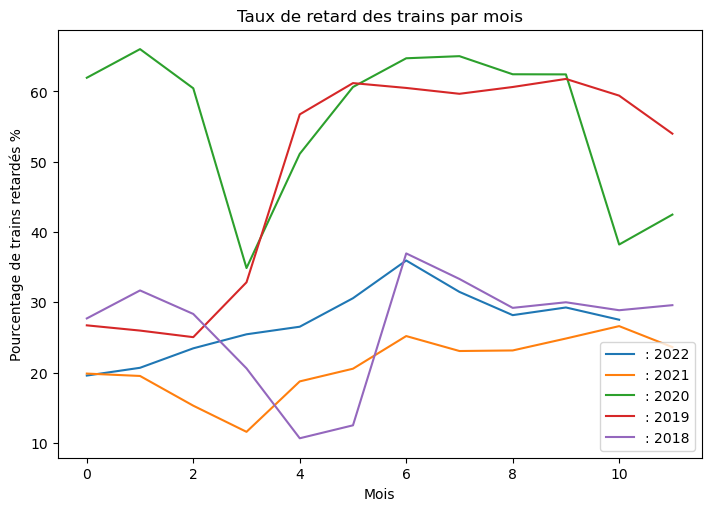

In [28]:
fig, ax = plt.subplots(figsize=(7, 5), layout='constrained')
#On trace la courbe pour chaque année renseignée dans le dataset
ax.plot(aggreg_mensuel(df_retards, 'prct_nb_train_depart_retard',2022), label=': 2022')
ax.plot(aggreg_mensuel(df_retards, 'prct_nb_train_depart_retard',2021), label=': 2021')
ax.plot(aggreg_mensuel(df_retards, 'prct_nb_train_depart_retard',2020), label=': 2020')
ax.plot(aggreg_mensuel(df_retards, 'prct_nb_train_depart_retard',2019), label=': 2019')
ax.plot(aggreg_mensuel(df_retards, 'prct_nb_train_depart_retard',2018), label=': 2018')
ax.set_xlabel('Mois')  
ax.set_ylabel('Pourcentage de trains retardés %') 
ax.set_title("Taux de retard des trains par mois")  
ax.legend()
plt.show()

Une tendance notable à la baisse des retards entre Février et Avril suivie d'une remontée jusqu'en Juin est à remarquer. Par ailleurs, les années 2019 et 2020 ont été particulièrement impactées au niveau des retards. Pour essayer de mieux mettre en valeur les phénomènes décris, nous allons tracer la courbe étalée sur l'entièreté de la période.

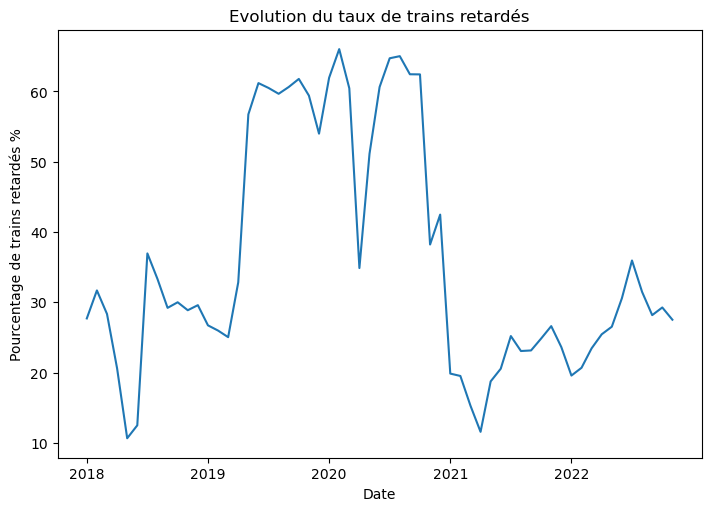

In [29]:
#On fait appel à la fonction aggreg_totale qui conctène juste les résultats de la fonction aggreg_mensuel sur les 4 années disponnibles.
R =  aggreg_totale(df_retards, 'prct_nb_train_depart_retard')
fig, ax = plt.subplots(figsize=(7, 5), layout='constrained')
ax.plot(R)
ax.set_xlabel('Date')  
ax.set_ylabel('Pourcentage de trains retardés %') 
ax.set_title("Evolution du taux de trains retardés")
plt.xticks([0,12,24,36,48],['2018', '2019', '2020', '2021', '2022'])
plt.show()

L'effet cyclique des retards des trains est encore plus évident. Au début de chaque nouvelle année, une diminution du pourcentage de trains en retards suivi d'une remontée à partir de la fin du premier tier de l'année sont observables. 

Il est maintenant intéressant de comparer le taux de retard avec le taux d'annulation afin de vérifier si une baisse du taux de retard est en fait compensée par une augmentation du taux d'annulation. Le même procédé est répété pour avoir la courbe des taux mensuels d'annulation.


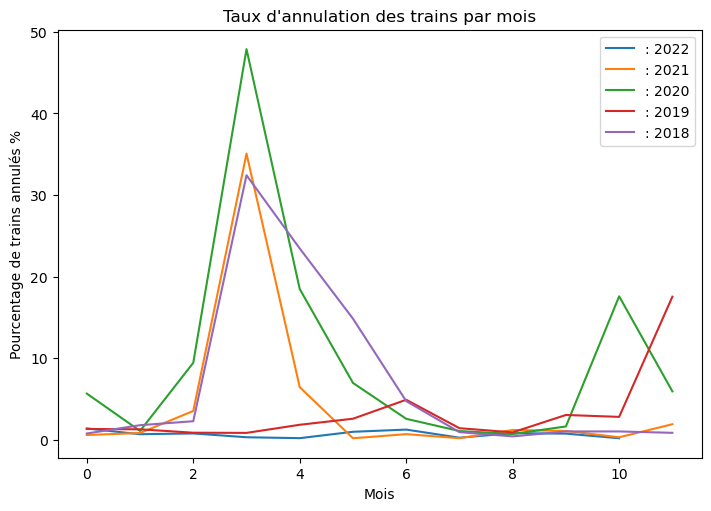

In [30]:
fig, ax = plt.subplots(figsize=(7, 5), layout='constrained')
ax.plot(aggreg_mensuel(df_retards, 'prct_nb_annulation',2022), label=': 2022')
ax.plot(aggreg_mensuel(df_retards, 'prct_nb_annulation',2021), label=': 2021')
ax.plot(aggreg_mensuel(df_retards, 'prct_nb_annulation',2020), label=': 2020')
ax.plot(aggreg_mensuel(df_retards, 'prct_nb_annulation',2019), label=': 2019')
ax.plot(aggreg_mensuel(df_retards, 'prct_nb_annulation',2018), label=': 2018')
ax.set_xlabel('Mois')  
ax.set_ylabel('Pourcentage de trains annulés %') 
ax.set_title("Taux d\'annulation des trains par mois")  
ax.legend()
plt.show()   

Entre février et avril, il y a un pic évident du nombre d'annulation des trains. La courbe étalée sur toute la période rend le phénomène encore plus lisible.


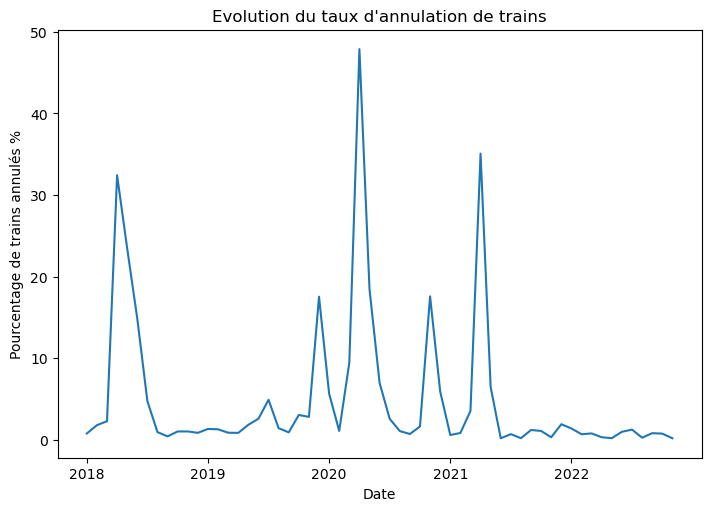

In [31]:
A = aggreg_totale(df_retards, 'prct_nb_annulation')
fig, ax = plt.subplots(figsize=(7, 5), layout='constrained')
ax.plot(A)
ax.set_xlabel('Date')  
ax.set_ylabel('Pourcentage de trains annulés %') 
ax.set_title("Evolution du taux d\'annulation de trains")
plt.xticks([0,12,24,36,48],['2018', '2019', '2020', '2021', '2022'])
plt.show()

Il est intéressant d'afficher sur le même graphe l'évolution du taux d'annulation et de retard pour mettre en avant le phénomène de substitution.

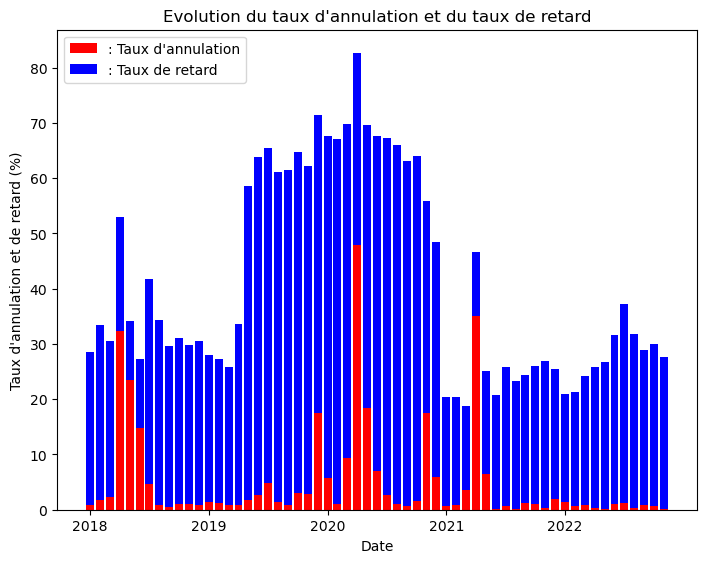

In [32]:
ind = np.arange(len(A)) 
width = 0.8
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(ind, A, width, color='r')
ax.bar(ind, R, width,bottom=A, color='b')
ax.set_ylabel('Taux d\'annulation et de retard (%)')
ax.set_xlabel('Date')
ax.set_title('Evolution du taux d\'annulation et du taux de retard')
ax.legend(labels=[': Taux d\'annulation', ': Taux de retard'])
plt.xticks([0,12,24,36,48],['2018', '2019', '2020', '2021', '2022'])
plt.show()

#### **2.2.1 Analyse descriptifve de l'évolution des causes de retard**

Nous nous intéressons aux motifs des retards des TGV de la SNCF. Pour cela, la même fonction aggreg_totale sera utile pour illustrer cette évolution dans le temps.

In [33]:
#Pour chaque cause, on crée la liste qui contient le pourcentage de responsabilité des retards sur chaque période
E = aggreg_totale(df_retards, 'prct_cause_externe')
I = aggreg_totale(df_retards, 'prct_cause_infra')
G = aggreg_totale(df_retards, 'prct_cause_gestion_trafic')
M = aggreg_totale(df_retards, 'prct_cause_materiel_roulant')
GG = aggreg_totale(df_retards, 'prct_cause_gestion_gare')
V = aggreg_totale(df_retards, 'prct_cause_prise_en_charge_voyageurs')

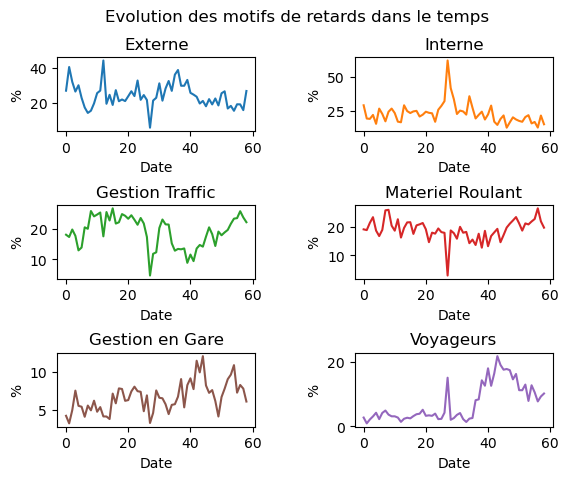

In [34]:
#On trace les 6 courbes d'évolution pour chaque motif de retard
fig, axs = plt.subplots(3, 2)
fig.suptitle('Evolution des motifs de retards dans le temps')
axs[0, 0].plot(E)
axs[0, 0].set_title('Externe')
axs[0, 1].plot(I, 'tab:orange')
axs[0, 1].set_title('Interne')
axs[1, 0].plot(G, 'tab:green')
axs[1, 0].set_title('Gestion Traffic')
axs[1, 1].plot(M, 'tab:red')
axs[1, 1].set_title('Materiel Roulant')
axs[2, 0].plot(GG, 'tab:brown')
axs[2, 0].set_title('Gestion en Gare')
axs[2, 1].plot(V, 'tab:purple')
axs[2, 1].set_title('Voyageurs')

for ax in axs.flat:
    ax.set(xlabel='Date', ylabel='%')
    plt.gcf().subplots_adjust(wspace = 0.5, hspace = 1)     

Les 6 courbes sont difficilement interprétables. Il est préférable de les afficher toutes sur un même graphe, grâce à la commande stackplot, pour mieux saisir les dynamiques. 

In [35]:
#On commence par créer la liste O qui contient le pourcentage des autres causes que celles indiquées dans notre dataset
O = []
for i in range(60):
    x = 100 - E[i]- I[i]- G[i]- M[i]- GG[i]- V[i]
    O.append(x)

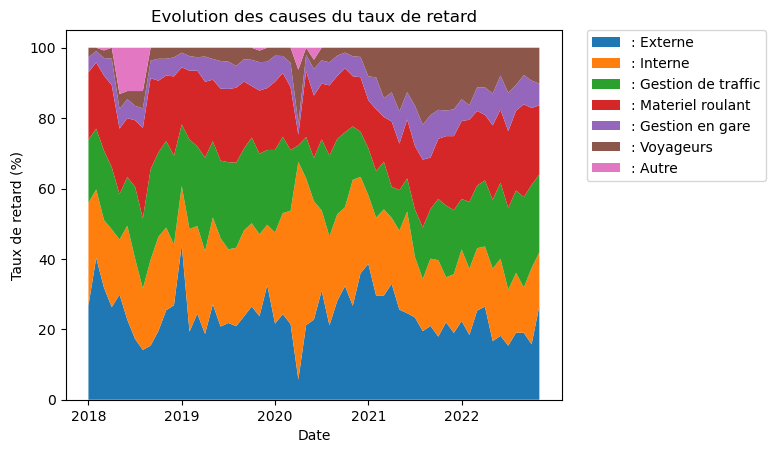

In [36]:
#On trace le graphe avec la fonction stackplot
C = [E, I, G, M, GG, V, O]
inde = range(1,61)
fig, ax = plt.subplots()
ax.stackplot(inde, C)
ax.set_ylabel('Taux de retard (%)')
ax.set_xlabel('Date')
ax.set_title('Evolution des causes du taux de retard')
ax.legend(labels=[': Externe', ': Interne',': Gestion de traffic',': Materiel roulant',': Gestion en gare',': Voyageurs', ': Autre' ], bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0.)
plt.xticks([1,13,25,37,49],['2018', '2019', '2020', '2021', '2022'])
plt.show()

Les causes externes, internes, gestion de trafics et matériel roulant représentent plus de 80% des motifs de retards avant 2021. Il est intéressant de voir qu'à partir de 2021, les retards causés par les voyageurs augmentent de façon étonnante. Dans la prochaine partie, nous établirons des liens de causalité entre le nombre de retard et des différents incidents avant de tenter de prédire l'évolution des perturbations du réseau SNCF.

## **3. MODÉLISATION des retards de la SNCF**

Nous cherchons à expliquer les retards grâce à des variables explicatives. Dans un premier temps, nous allons modéliser le jeu de données existant en adoptant une approche économétrique. Puis, nous nous intéresserons à la prédiction de nouvelles données avec une approche plus orientée machine learning.

### **3.1. Préparation des données pour la régression**

In [37]:
#Récupération de la base 
df_retards = df_retards_initial.copy()

In [38]:
#Listage des différentes causes de retards du dataframe
causes_retards = ['cause_materiel_roulant', 'cause_infra', 'cause_gestion_trafic', 'cause_externe', 'cause_gestion_gare', 'cause_prise_en_charge_voyageurs']
causes_retards_large = ['cause_materiel_roulant', 'cause_infra', 'cause_gestion_trafic', 'cause_externe', 'cause_gestion_gare', 'cause_prise_en_charge_voyageurs', 'nb_train_prevu']

In [39]:
#On passe les causes de retards en niveau plutôt qu'en pourcentage pour homogénéiser les données
#On utilise pour cela la fonction niveau qui est dans le fichier fonctions.py
niveau(df_retards,df_retards['nb_train_retard_arrivee'], causes_retards).head(2)

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,nb_train_depart_retard,retard_moyen_depart,retard_moyen_tous_trains_depart,...,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs,cause_materiel_roulant,cause_infra,cause_gestion_trafic,cause_externe,cause_gestion_gare,cause_prise_en_charge_voyageurs
0,2018-01,National,BREST,PARIS MONTPARNASSE,225,284,3,4,2.250000,0.032028,...,0.000000,13.333333,0.000000,0.0,2.533333,10.133333,0.000000,6.333333,0.000000,0.0
1,2018-01,National,PARIS MONTPARNASSE,ANGOULEME,126,239,4,36,6.347685,0.751560,...,19.230769,23.076923,3.846154,0.0,6.461538,10.769231,5.384615,4.307692,1.076923,0.0


In [40]:
#Elimination des valeurs excessives
df_retards = df_retards.drop(df_retards[df_retards['nb_train_retard_arrivee']>170].index)
df_retards = df_retards.drop(df_retards[df_retards['nb_train_retard_arrivee']==1].index)

(array([2359., 1979., 1198.,  636.,  383.,  210.,  112.,   67.,   37.,
          18.]),
 array([  2. ,  18.7,  35.4,  52.1,  68.8,  85.5, 102.2, 118.9, 135.6,
        152.3, 169. ]),
 <BarContainer object of 10 artists>)

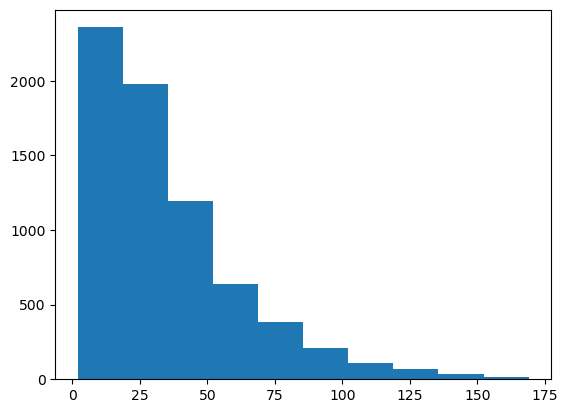

In [41]:
#Visualisation des données pour la variable expliquée
plt.hist(df_retards['nb_train_retard_arrivee'])

In [42]:
#Symétrisation des données en passant au log
df_retards.loc[:,'log_nb_train_retard_arrivee']  = np.log(df_retards['nb_train_retard_arrivee'])

In [43]:
#Copie du dataframe initiale (par securité)
df_retards_2 = df_retards.copy()

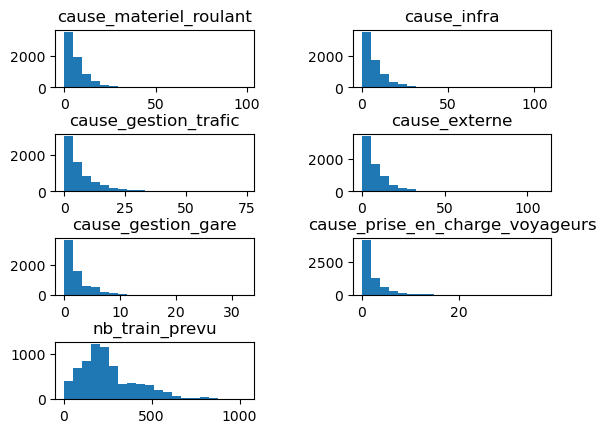

In [44]:
#Visualisation des données pour les variables explicatives
        
afficher_hist(df_retards, causes_retards_large)

In [45]:
#Symétrisation en passant au log pour les 7 premières variables
for i in range(len(causes_retards_large[:-1])):
    df_retards.loc[:,'log_'+causes_retards_large[i]]  = np.log(df_retards[causes_retards_large[i]]+1)

In [46]:
#Listage des "causes" en log
log_causes_retards = ['log_cause_materiel_roulant', 'log_cause_infra', 'log_cause_gestion_trafic', 'log_cause_externe', 'log_cause_gestion_gare', 'log_cause_prise_en_charge_voyageurs']
log_causes_retards_large = ['log_cause_materiel_roulant', 'log_cause_infra', 'log_cause_gestion_trafic', 'log_cause_externe', 'log_cause_gestion_gare', 'log_cause_prise_en_charge_voyageurs', 'nb_train_prevu']

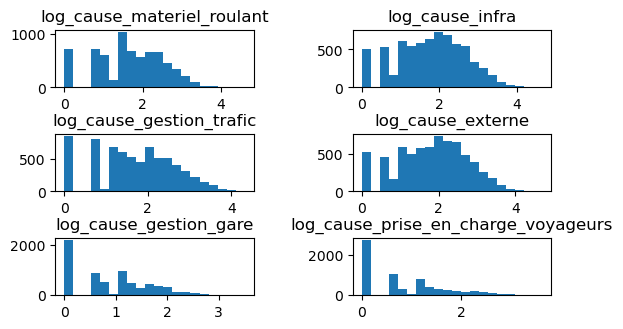

In [47]:
#Visualisation des données symétrisées

afficher_hist(df_retards, log_causes_retards_large[:-1])

In [48]:
#Recalibrage des données 

features = df_retards[log_causes_retards_large]
features = StandardScaler().fit(features.values).transform(features.values)
df_retards[log_causes_retards_large] = features
df_retards.head(2)

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,nb_train_depart_retard,retard_moyen_depart,retard_moyen_tous_trains_depart,...,cause_externe,cause_gestion_gare,cause_prise_en_charge_voyageurs,log_nb_train_retard_arrivee,log_cause_materiel_roulant,log_cause_infra,log_cause_gestion_trafic,log_cause_externe,log_cause_gestion_gare,log_cause_prise_en_charge_voyageurs
0,2018-01,National,BREST,PARIS MONTPARNASSE,225,0.146255,3,4,2.250000,0.032028,...,6.333333,0.000000,0.0,2.944439,-0.457946,0.688447,-1.721556,0.165287,-1.191275,-0.994188
1,2018-01,National,PARIS MONTPARNASSE,ANGOULEME,126,-0.124384,4,36,6.347685,0.751560,...,4.307692,1.076923,0.0,3.332205,0.394474,0.751027,0.199253,-0.189600,-0.239078,-0.994188


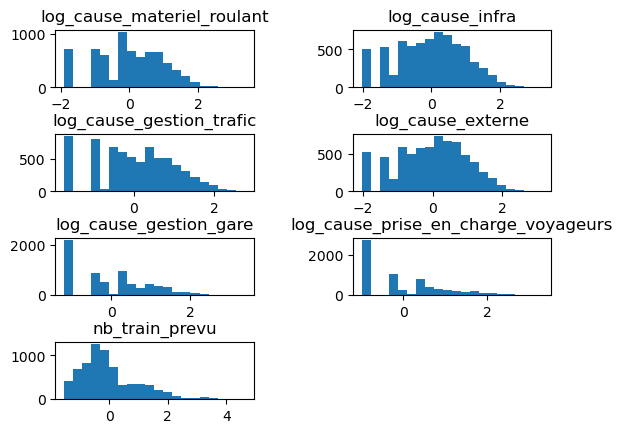

In [49]:
#Visualisation des données

afficher_hist(df_retards, log_causes_retards_large)

### **3.2 Première régression à une variable**

In [50]:
#Appel de la fonction régression du fichier fonctions.py

results_s = regression(df_retards[['cause_externe']], df_retards[['nb_train_retard_arrivee']])
print(results_s.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     8087.
Date:                Wed, 21 Dec 2022   Prob (F-statistic):               0.00
Time:                        11:24:58   Log-Likelihood:                -30559.
No. Observations:                6999   AIC:                         6.112e+04
Df Residuals:                    6997   BIC:                         6.114e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            15.8059      0.311     50.894

Le R^2, caractéristique du pouvoir explicatif du modèle, est d'environ 0.54 (1 correspondant à une prédiction parfaite). De plus, la variable cause_externe est significative.

### **3.3 Régression à plusieurs variables**

In [51]:
#On passe maintenant à une régression à plusieurs variables
results = regression(df_retards[log_causes_retards_large], df_retards[['nb_train_retard_arrivee']])
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     4412.
Date:                Wed, 21 Dec 2022   Prob (F-statistic):               0.00
Time:                        11:25:05   Log-Likelihood:                -27334.
No. Observations:                6999   AIC:                         5.468e+04
Df Residuals:                    6991   BIC:                         5.474e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

**Analyse des coefficients**

Le R^2 de la régression est satisfaisant et a largement augmenté (en ajoutant des variables, on augmente le pouvoir explicatif du modèle sous certaines conditions). Toutes les variables sont explicatives au seuil de 1%. Le coefficient le plus élevé est celui de log_cause_gestion_trafic. Il signifie qu'une hausse de 1% des incidents de gestion de trafics (1 + nombre de problèmes de gestion de trafic) augmente par 7 le nombre de trains en retard par ligne et par mois.


**Conclusion** : selon cette régression, l'incident impliquant le plus de retard (en nombre) est la gestion du trafic. 

Dans quelle mesure la SNCF pourrait-elle réduire le nombre de retards en travaillant sur ce point ? Pour le savoir, il faut adopter une approche plus orientée machine learning qui permet de faire des prédictions. C'est l'objet de la partie suivante.

### **3.4 Prédiction**

intercept :  3.1979548146250694
coeffs :  [0.20484675 0.22786916 0.22872406 0.24847478 0.08912912 0.09432429
 0.03047589]
rsq :  0.8744545721212804
rmse :  0.3173997731750471



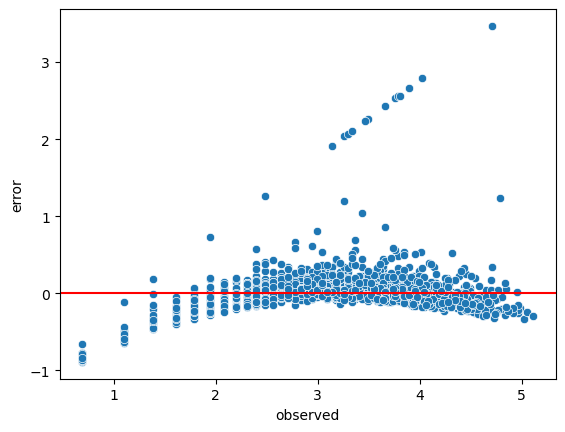

In [52]:
x = df_retards[log_causes_retards_large]
y = df_retards['log_nb_train_retard_arrivee']

prediction(x, y)
print()

Le modèle souffre d'un problème de spécification. Nous allons procéder à la sélection de variables avec le LASSO.

### **3.5 Sélection des variables avec  le LASSO**

In [53]:
#Estimation du modèle LASSO
X_train = prediction(x, y, afficher = False)[0]
y_train = prediction(x, y, afficher = False)[1]

lasso1 = Lasso(fit_intercept=True,normalize=False, alpha = 0.00655).fit(X_train,y_train)

#selection de variables
features_selec = x.columns[np.abs(lasso1.coef_)>0].tolist()
features_selec 

#N'hésitez pas à refaire tourner la cellule si elle ne selectionne aucune ou une seule variable

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


['log_cause_infra', 'log_cause_externe']

In [54]:
#corrélations entre les variables sélectionnées
corr = df_retards[features_selec].corr()

plt.figure()
p = corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)
p

/tmp/ipykernel_295/2425215618.py:5: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  p = corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)


,log_cause_infra,log_cause_externe
log_cause_infra,1.00,0.56
log_cause_externe,0.56,1.00


<Figure size 640x480 with 0 Axes>

Les variables ne sont pas exagérément corrélées. Lorsque la variable nb_train_prevu est sélectionnée, c'est la plus corrélée aux autres variables ce qui est assez intuitif : plus on prévoit de trains, plus il y a des chances d'avoir de problèmes de gestion trafic ou de gestion en gare par exemple. 

intercept :  3.199749287999475
coeffs :  [0.44684081 0.43630481]
rsq :  0.7465882146079539
rmse :  0.46187002046554293



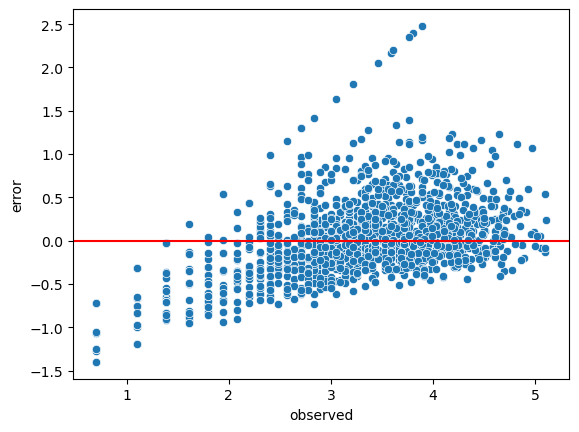

In [55]:
x = df_retards[features_selec]
y = df_retards['log_nb_train_retard_arrivee']

prediction(x, y)
print()

Notre modèle souffre toujours d'un problème de spécification, mais il est tout de même meilleur que le précédent. 

## **Bonus: Jeu interactif**

En plus de nos analyses statistiques et économétriques, nous avons profité de ce projet Python pour développer un petit jeu. Vous pouvez maintenant ouvrir le dossier **mini_jeu** afin d'essayer de sauver vos fêtes de fin d'année en évitant tous les retards.

## **Conclusion**

#### **Apports**

Ce projet nous a permis de mettre en application l'ensemble des notions vu pendant le cours de **Python pour la data science** dispensé en 2ème année à l'ENSAE Paris. Il nous a permis de nous confronter à des problèmes de natures diverses et à les surmonter grâce à différents outils. Git, par exemple, a été d'une aide précieuse pour la réalisation de ce projet, au même titre que nos connaissances théoriques acquises avec le cours **d'Econometrics** de l'ENSAE. Le groupe s'est investi pleinement dans chacune des parties du projet et en a retiré des enseignements utiles.

#### **Bilan**

Grâce à **l'Analyse statistique et graphique**, nous avons pu identifier et illustrer la périodicité des retards ainsi que l'effet de substitution entre retards et annulations. Cela peut donner des premières pistes de travail pour la SNCF afin de mieux cibler de potentielles mesures en vue de réduire le nombre de perturbations sur le réseau ferré qu'elle gère. L'analyse des causes des retards, principalement menée dans la partie **Modélisation**, vient renforcer et préciser nos conclusions précédentes. La principale source de perturbation a pu être identifiée, à savoir les incidents de gestion du trafics. Nous avons essayé d'en prédire les conséquences futures. Cela peut être un outil précieux pour les gestionnaires de la SNCF afin de mieux anticiper les perturbations et proposer des réponses plus adaptées aux usagers.

#### **Limites**

Bien entendu, nous aurions voulu pousser plus loin notre analyse dans chacune des parties. Une piste intéressante envisagée (mais finalement délaissé faute de temps) aurait été de croiser notre analyse des retards avec celle de la fréquentation. Cependant, nous avons été bloqués par les formats trop différents des 2 datasets qui rendaient compliqué leur concaténation (celui des retards traite de lignes de trains alors que celui des fréquentations traite des gares). Il pourrait être intéressant de reprendre ce travail un peu fastidieux afin de préciser encore un peu plus nos analyses. Nous pourrions utiliser encore d'autres datasets disponibles sur l'API afin d'identifier de nouveaux liens de causalités et d'améliorer nos prédictions.